In [1]:
import h5py
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import sys
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
import torch
from torch.utils.data import DataLoader
from common.args import Args
import net_utils as nu
import sigpy as sp
import sigpy.plot as pl
%matplotlib notebook
import argparse
import pathlib
from skimage.metrics import structural_similarity as np_ssim
import vd_spiral

%load_ext autoreload
%autoreload 2

In [2]:
sys.argv=['']
def create_arg_parser():
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=8, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=500, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.001, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=40,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.,
                        help='Strength of weight decay regularization')

    parser.add_argument('--report-interval', type=int, default=100, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cuda',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/train/spiral',
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/train/unet_spiral/model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/spiral_unet',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=320, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[0,1] , help='GPUS used')
    return parser
args=create_arg_parser().parse_args()

In [3]:
file='/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002425.h5'
with h5py.File(file,'r') as f:
    print("Keys: %s"%f.keys())
    data=np.array(list(f['kspace']))
    f.close()

Keys: <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>


In [41]:
full=args.resolution*args.resolution
print(full)
us_factor=4
#N=30000;
N=full//us_factor
print(data.shape)
nRounds=100;
PowCoeff=2; 
m_size=320;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);

102400
(16, 20, 640, 320)


102400
25600
(25600, 2)
(20, 320, 320)


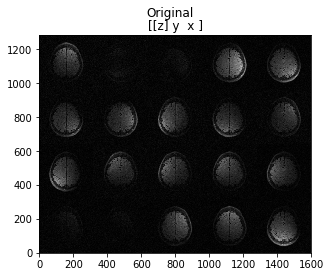

(20, 320, 320)


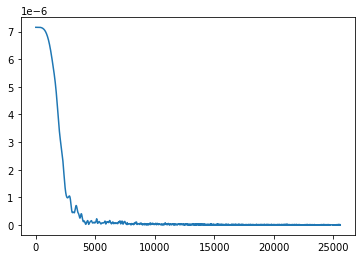

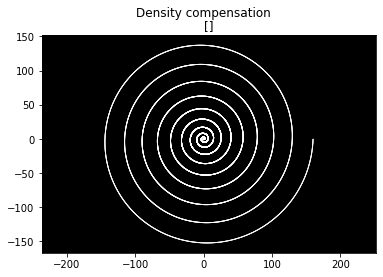

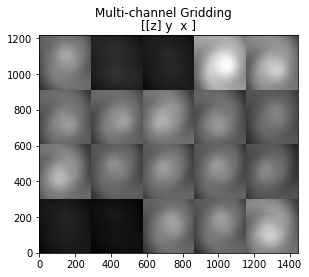

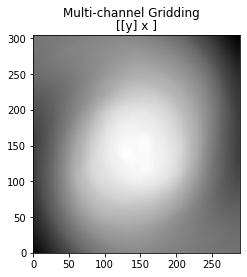

In [44]:
full=args.resolution*args.resolution
print(full)
us_factor=4
#N=30000;
N=full//us_factor
print(N)
nRounds=10;
PowCoeff=2; 
m_size=160;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);
traj=np.swapaxes(traj,0,1)
print(traj.shape)
img=abs(nu.make_ift(data))[8,:,160:480,:]
print(img.shape)
pl.ImagePlot(img,z=0,title='Original')
print(img.shape)
ksp = sp.nufft(img, traj,3)
plt.plot(abs(ksp)[8])
#dcf = (traj[..., 0]**2 + traj[..., 1]**2)**0.5
dcf=np.array([1 for i in range(traj.shape[0])])
pl.ScatterPlot(traj, dcf, title='Density compensation')
img_grid = sp.nufft_adjoint(ksp, traj)
pl.ImagePlot(img_grid,z=0,title='Multi-channel Gridding')
pl.ImagePlot(nu.rsos(img_grid,0),title='Multi-channel Gridding')

In [35]:
def check_density(traj,d=[],r0=1):
    d_p=[]
    temp=1
    r=r0
    rs=[]
    for i in range(len(traj)):
        #print((traj[i, 0]**2 + traj[i, 1]**2)**0.5)
        #print("r",r)
        if (traj[i, 0]**2 + traj[i, 1]**2)**0.5>r:
            #print(r)
            d.append(temp)
            for i in range(temp-1):
                d_p.append(temp)
            rs.append(r)
            temp=1
            r=np.sqrt(r0+r**2)
            while (traj[i, 0]**2 + traj[i, 1]**2)**0.5>r:
                d.append(temp)
                r=np.sqrt(r0+r**2)
                rs.append(r)
            temp=2
        else:
            temp+=1
    d.append(temp)
    for i in range(temp-1):
        d_p.append(temp)
    #print(d)
    return np.array(d),np.array(rs),np.array(d_p)

In [36]:
dcf,rs,d_p=check_density(traj)
print(np.sum(dcf))
print(dcf.shape)
print(rs)

39104
(13504,)
[  1.           1.41421356   1.73205081 ... 116.19380362 116.1981067
 116.20240961]


In [37]:
def get_dcf(points,dcf,rs):
    for i in range(len(points)):
        for j in range(len(points[i])):
            print(j)
            idx=0
            while (i-args.resolution)**2 + (j-args.resolution)**2>rs[idx]:
                if idx==len(rs)-1:
                    break
                idx+=1
            points[i,j]=points[i,j]*1/dcf[idx]
    return points

def apply_dcf(ksp,dp):
    return ksp/dp

In [38]:
print(apply_dcf(ksp,d_p))

[[ 1.57643149e-09-1.10290748e-26j  1.57643150e-09-2.96782673e-17j
   1.57643152e-09-1.18970271e-16j ...  2.64370915e-09+6.26081957e-10j
   3.02829761e-09+9.66503147e-10j  3.27928853e-09+7.66821245e-10j]
 [ 1.33560600e-09-8.16968506e-27j  1.33560600e-09-1.88361135e-17j
   1.33560602e-09-7.53674011e-17j ... -9.77292584e-10+1.51658154e-09j
   1.89760531e-10+5.81973695e-10j  2.29113587e-09-9.45029795e-11j]
 [ 3.69778862e-09-1.63393701e-26j  3.69778865e-09-7.42983202e-17j
   3.69778874e-09-2.99145960e-16j ... -6.06490992e-10-2.20496104e-09j
  -1.97044843e-09-1.29711556e-09j -3.01776210e-09-4.89641375e-10j]
 ...
 [ 1.71033871e-09-7.65907975e-27j  1.71033872e-09+7.20548016e-18j
   1.71033874e-09+2.86035191e-17j ...  3.79779416e-10-3.80800898e-10j
   2.42284989e-09-4.54377020e-10j  5.01216839e-09-2.24071199e-10j]
 [ 5.31963272e-09-1.79733071e-26j  5.31963277e-09+2.69824222e-16j
   5.31963291e-09+1.07539033e-15j ... -2.49294644e-09-2.03327161e-09j
  -2.25123619e-09-3.03725150e-10j -2.04078968e-

102400
12800
(16, 20, 640, 320)
(20, 320, 320)


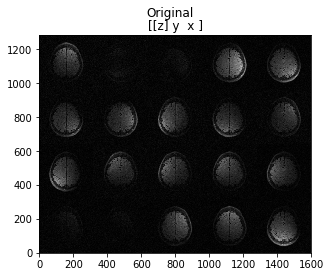

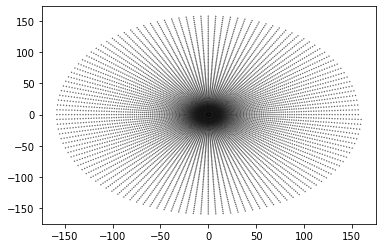

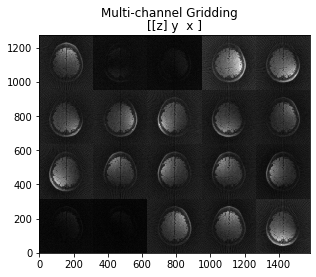

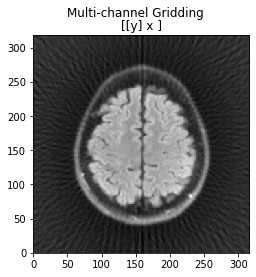

In [39]:
full=args.resolution*args.resolution
print(full)
us_factor=8
#N=30000;
N=full//us_factor
print(N)
nRounds=100;
PowCoeff=2; 
m_size=160;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);

traj=np.swapaxes(traj,0,1)
print(data.shape)
img=abs(nu.make_ift(data))[8,:,160:480,:]
print(img.shape)
pl.ImagePlot(img,z=0,title='Original')
ksp = sp.nufft(img, traj,3)
plt.scatter(traj[:,0],traj[:,1], c=np.real(ksp[8]),s=0.1)
plt.gray()
plt.show()
dcf,rs,d_p=check_density(traj,r0=1)
img_grid = sp.nufft_adjoint(apply_dcf(ksp,d_p), traj)
pl.ImagePlot(img_grid,z=0,title='Multi-channel Gridding')
pl.ImagePlot(nu.rsos(img_grid,0),title='Multi-channel Gridding')

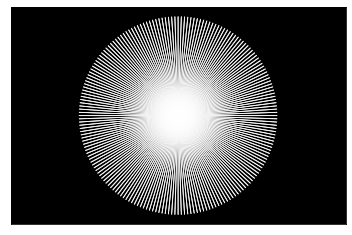

In [11]:
coord = np.load('projection_coord.npy')
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
dcf=coord[..., 0]/coord[..., 0]
pl.ScatterPlot(coord, dcf, title='Density compensation',hide_axes=True)
plt.show()

102400
5120


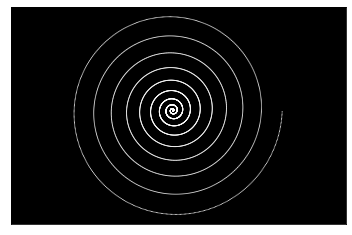

In [12]:
full=args.resolution*args.resolution
print(full)
us_factor=20
#N=30000;
N=full//us_factor
print(N)
nRounds=10;
PowCoeff=2; 
m_size=160;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);
traj=np.swapaxes(traj,0,1)
#dcf = (traj[..., 0]**2 + traj[..., 1]**2)**0.5
dcf=np.array([1 for i in range(traj.shape[0])])
pl.ScatterPlot(traj, dcf, title='Density compensation',hide_axes=True)

torch.Size([300, 500])


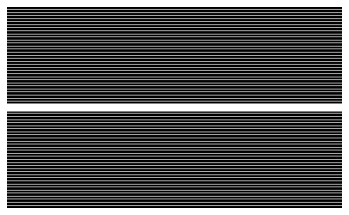

In [15]:
full=nu.apply_mask(torch.from_numpy(np.ones((300,500))).unsqueeze(0))[0].squeeze(0)
print(full.shape)
plt.imshow(full==0,cmap="binary")
plt.axis("off")
plt.show()

torch.Size([300, 500])


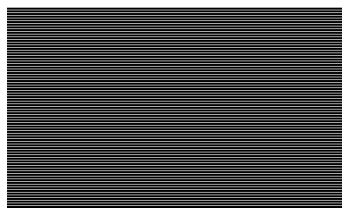

In [17]:
full=nu.apply_mask(torch.from_numpy(np.ones((1,300,500))).unsqueeze(0),mode="plain")[0][0].squeeze(0)
print(full.shape)
plt.imshow(full==0,cmap="binary")
plt.axis("off")
plt.show()